# Temporal Anomaly Detection Dataset Challenge
Suppose our business is a pop-up store and relies on selling items to large groups of people.

We seek to make critical business decisions of where to locate our business based on anomalous activity on a certain pedestrian trail in Seattle. If there is an unusual amount of activity on the trail, we would like to relocate to the trail. Otherwise, we would find another location.

The dataset you will be using is collected by the City of Seattle using a combination of infrared and pressure sensors and consists of 5 features about the trail.

Your task is to create an anomaly detection model which can use these features to determine if the activity on the trail 3 hours in the future will be anomalous

#### Project specifications:
- Create an anomaly detection model to predict anomalies 3 hours in the future
- Provide clear visualizations to explain your results
- Consider experimental design choices for the results to be valid in production
- Describe how you would use these results to recommend an action to the business
- Please spend about 3 hours on this challenge
    - If you have extra time, please consider doing another investigation with the data that you think could help the business owners. This is completely optional and will only be used to kickstart our discussions of your work


<b>Definition of Anomalous</b>: The criteria for anomalous activity is at least 500 total people on the trail in the past
hour.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import os

from typing import List

## Data Loading

In [2]:
data_dir = "../data"
fname = "burke-gilman-trail-north-of-ne-70th-st-bike-and-ped-counter.csv"
data_fpath = os.path.join(data_dir, fname)

In [3]:
df = pd.read_csv(data_fpath)
df

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
0,2014-01-01T00:00:00.000,15.0,0.0,2.0,2.0,11.0
1,2014-01-01T01:00:00.000,9.0,1.0,0.0,1.0,7.0
2,2014-01-01T02:00:00.000,9.0,0.0,0.0,0.0,9.0
3,2014-01-01T03:00:00.000,19.0,0.0,0.0,0.0,19.0
4,2014-01-01T04:00:00.000,19.0,0.0,0.0,0.0,19.0
...,...,...,...,...,...,...
52579,2019-12-31T19:00:00.000,6.0,2.0,1.0,1.0,2.0
52580,2019-12-31T20:00:00.000,2.0,0.0,0.0,0.0,2.0
52581,2019-12-31T21:00:00.000,3.0,1.0,2.0,0.0,0.0
52582,2019-12-31T22:00:00.000,1.0,0.0,0.0,0.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        52584 non-null  object 
 1   BGT North of NE 70th Total  50249 non-null  float64
 2   Ped South                   50249 non-null  float64
 3   Ped North                   50249 non-null  float64
 4   Bike North                  50249 non-null  float64
 5   Bike South                  50249 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.4+ MB


In [5]:
df.describe()

,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
count,50249.000000,50249.000000,50249.000000,50249.000000,50249.000000
mean,73.948158,20.321857,9.827698,21.846106,21.952497
std,191.864307,135.919922,41.630237,33.290811,62.598346
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,1.000000,1.000000
50%,33.000000,5.000000,4.000000,8.000000,9.000000
75%,94.000000,14.000000,13.000000,30.000000,32.000000
max,10493.000000,4054.000000,4095.000000,794.000000,8191.000000


## Initial Review of Data
- Looks like size of dataset is relatively small (52k samples with 6 columns and ~2.4MB in memory)
- There exist some null values (2335 rows where there exist null values in every column other than "Date")
- We're dealing primarily with datetime and numeric data types (discrete integer values bounded by [0, inf) )
- This data is a time series of count data which will affect our choices for modeling

### Data Description from Challenge PDF
| Feature Name               | Description                                           |
|----------------------------|-------------------------------------------------------|
| Date                       | Timestamp with 1-hour cadence                         |
| Ped South                  | # of pedestrians walking south within the past hour   |
| Ped North                  | # of pedestrians walking north within the past hour   |
| Bike South                 | # of bikes riding south within the past hour          |
| Bike North                 | # of bikes riding north within the past hour          |
| BGT North of NE 70th Total | Total # of pedestrians and bikes within the past hour |


Total People = Pedestrians + Bikers

Target Variable = "BGT North of NE 70th Total"
- This will be the primary indicator for us to determine if a data point is anomalous or not

Assumption: North and South are both just directions of the same single trail

## Initial Data Cleaning and Preprocessing

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

df['Ped Total'] = df['Ped North'] + df['Ped South']
df['Bike Total'] = df['Bike North'] + df['Bike South']

df['Day'] = df[ "Date"].dt.day
df['Hour'] = df[ "Date"].dt.hour

df['Day of Week'] = df[ "Date"].dt.dayofweek
df['Month'] = df["Date"].dt.month
df['Year'] = df[ "Date"].dt.year


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        52584 non-null  datetime64[ns]
 1   BGT North of NE 70th Total  50249 non-null  float64       
 2   Ped South                   50249 non-null  float64       
 3   Ped North                   50249 non-null  float64       
 4   Bike North                  50249 non-null  float64       
 5   Bike South                  50249 non-null  float64       
 6   Ped Total                   50249 non-null  float64       
 7   Bike Total                  50249 non-null  float64       
 8   Day                         52584 non-null  int64         
 9   Hour                        52584 non-null  int64         
 10  Day of Week                 52584 non-null  int64         
 11  Month                       52584 non-null  int64     

In [7]:
df.describe()

,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South,Ped Total,Bike Total,Day,Hour,Day of Week,Month,Year
count,50249.000000,50249.000000,50249.000000,50249.000000,50249.000000,50249.000000,50249.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000
mean,73.948158,20.321857,9.827698,21.846106,21.952497,30.149555,43.798603,15.726609,11.500000,3.000000,6.523962,2016.499772
std,191.864307,135.919922,41.630237,33.290811,62.598346,162.466084,80.819312,8.798896,6.922252,2.000019,3.448452,1.707485
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2014.000000
25%,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,8.000000,5.750000,1.000000,4.000000,2015.000000
50%,33.000000,5.000000,4.000000,8.000000,9.000000,10.000000,19.000000,16.000000,11.500000,3.000000,7.000000,2016.000000
75%,94.000000,14.000000,13.000000,30.000000,32.000000,27.000000,64.000000,23.000000,17.250000,5.000000,10.000000,2018.000000
max,10493.000000,4054.000000,4095.000000,794.000000,8191.000000,5118.000000,8191.000000,31.000000,23.000000,6.000000,12.000000,2019.000000


## Time Series Analysis

In [8]:
def plot_features(
    df:pd.DataFrame, 
    index:str="Date", 
    features:List[str]=['Ped Total', 'Bike Total'],
    plot_type:str="line",
    xlim:tuple=None,
    ylim:tuple=None,
):
    """Function to plot features with respect to a given index

    Args:
        df (pd.DataFrame): data DataFrame
        index (str, optional): column to use as the x-axis. Defaults to "Date".
        features (List[str], optional): list of feature columns to use along y-axis. Defaults to ['Ped Total', 'Bike Total'].
        plot_type (str, optional): type of plot to create. Defaults to "line". See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html
        xlim (tuple, optional): lmits on x-axis. Defaults to None.
        ylim (tuple, optional): limits on y-axis. Defaults to None.
    """
    colors = ['b','g', 'r']
    all_cols = [index] + features
    df_temp = df[all_cols]
    ax = None
    for i, feat in enumerate(features):
        ax = df_temp.plot(
            index, 
            feat, 
            kind=plot_type, 
            ax=ax, 
            label=feat, 
            color=colors[i],
            xlim=xlim,
            ylim=ylim
        )
        ax.set_xlabel(index)
        ax.set_ylabel("Counts")

### Visualizing the Data

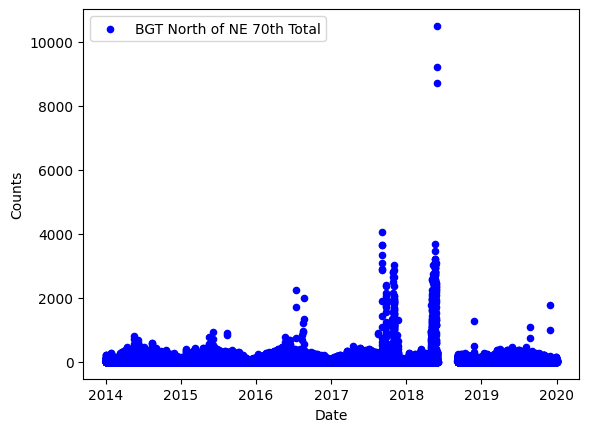

In [9]:
plot_features(
    df,
    index="Date", 
    features=["BGT North of NE 70th Total"], 
    plot_type="scatter"
)

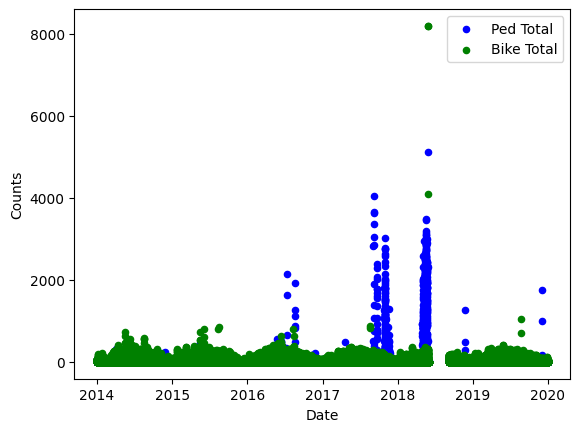

In [10]:
plot_features(
    df, 
    index="Date", 
    features=['Ped Total', 'Bike Total'],  
    plot_type="scatter"
)

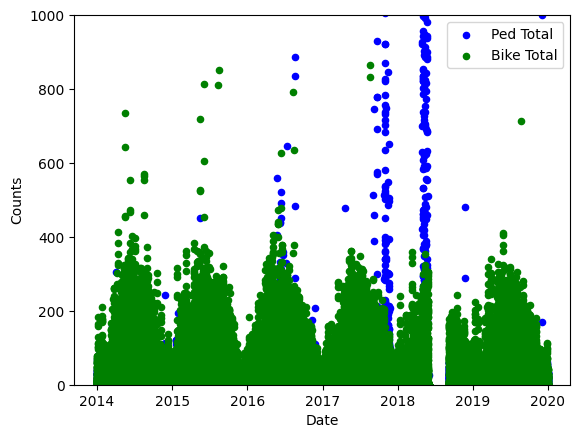

In [11]:
plot_features(
    df, 
    index="Date", 
    features=['Ped Total', 'Bike Total'],  
    plot_type="scatter",
    ylim=(0, 1000)
)

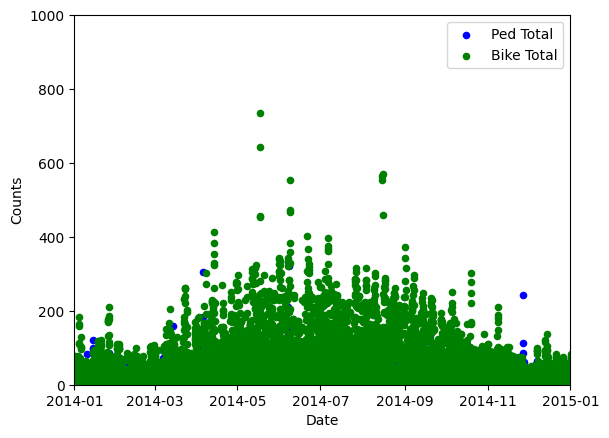

In [12]:
plot_features(
    df, 
    index="Date", 
    features=['Ped Total', 'Bike Total'],  
    plot_type="scatter",
    xlim=(df['Date'].min(), df['Date'].min() + pd.offsets.DateOffset(years=1)),
    ylim=(0, 1000)
)

### Analysis

- Looks like there is seasonality to this data
- Chunk of time is missing
- Most counts are < 500, but there exist a non-trivial amount of data > 500

### Handling Missing Values - Intial Thoughts

Based on the visualizations above, it looks like there is a continuous time window of data that is missing. We could do a few things in this scenario:
- Drop all samples with null columns
- BackFill or ForwardFill these values
- Interpolate these datapoints
- Use the previous years' data to estimate these missing data points

We'd like to give our model as much data as possible with a consistent interval so dropping only null samples may not be the best choice. Additionally, because there is such a large window of time that is missing, filling in data based on previous/next existing values as well as simple linear interpolation will result in poor synthetic samples. As a result, we will choose to go with the last option of estimating these samples based on previous years' data (i.e. looking at the same time window each year before it). 

Of course, with this approach, we are assuming that data points within this gap window will be similar to those in previous and future years' windows as well.


In [13]:
df_null = df[df.isna().any(axis=1)]
df_null

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South,Ped Total,Bike Total,Day,Hour,Day of Week,Month,Year
5337,2014-08-11 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,9,0,8,2014
6586,2014-10-02 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,10,3,10,2014
9563,2015-02-03 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,11,1,2,2015
10346,2015-03-08 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,2,6,3,2015
19250,2016-03-13 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,2,6,3,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41020,2018-09-06 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,3,9,2018
41021,2018-09-06 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,5,3,9,2018
41022,2018-09-06 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6,3,9,2018
41023,2018-09-06 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,7,3,9,2018


In [14]:
df_null.groupby('Year').count()

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South,Ped Total,Bike Total,Day,Hour,Day of Week,Month
Year,,,,,,,,,,,,
2014,2,0,0,0,0,0,0,0,2,2,2,2
2015,2,0,0,0,0,0,0,0,2,2,2,2
2016,1,0,0,0,0,0,0,0,1,1,1,1
2017,1,0,0,0,0,0,0,0,1,1,1,1
2018,2329,0,0,0,0,0,0,0,2329,2329,2329,2329


In [15]:
window_min, window_max = df_null[df_null.Year.eq(2018)]['Date'].min(), df_null[df_null.Year.eq(2018)]['Date'].max()
print(f"Window Min: {window_min}\nWindow Max: {window_max}")

Window Min: 2018-03-11 02:00:00
Window Max: 2018-09-06 08:00:00


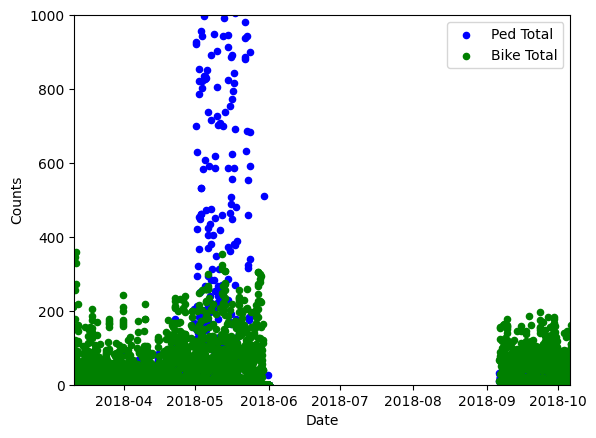

In [16]:
plot_features(
    df, 
    index="Date", 
    features=['Ped Total', 'Bike Total'],  
    plot_type="scatter",
    xlim=(window_min, window_max+pd.offsets.DateOffset(months=1)),
    ylim=(0, 1000)
)

In [17]:
df_null[df_null.Year.eq(2018)]

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South,Ped Total,Bike Total,Day,Hour,Day of Week,Month,Year
36722,2018-03-11 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,2,6,3,2018
38697,2018-06-01 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,4,6,2018
38698,2018-06-01 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,10,4,6,2018
38699,2018-06-01 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,11,4,6,2018
38700,2018-06-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,12,4,6,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41020,2018-09-06 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,3,9,2018
41021,2018-09-06 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,5,3,9,2018
41022,2018-09-06 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6,3,9,2018
41023,2018-09-06 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,7,3,9,2018


In [18]:
total_null_count = len(df_null[df_null.Year.eq(2018)].index)
null_count_gap = len(df_null[df_null.Year.eq(2018) & df_null.Month.ge(6) & df_null.Month.le(9)].index)

print(f"No. of Samples in 2018 that are null and not within gap: {total_null_count-null_count_gap}")

No. of Samples in 2018 that are null and not within gap: 1


Insight: looks like most of the missing data is in the year that we expected (2018) and within the specific gap that we saw earlier (06/2018 - 09/2018)

In [19]:
# Handle Null Data not in Gap
df[df.Year.ne(2018)] = df[df.Year.ne(2018)].fillna(method="ffill")
df[df.Year.ne(2018)] = df[df.Year.ne(2018)].fillna(method="bfill")
df[df.Year.eq(2018) & df.Month.lt(6)] = df[df.Year.eq(2018) & df.Month.lt(6)].fillna(method='ffill')

# Handle Null Data within Gap
gap_min_month, gap_max_month = df[df.isna().any(axis=1)]['Month'].min(), df[df.isna().any(axis=1)]['Month'].max()
df_null = df[df.isna().any(axis=1)]
print(f"Gap Min Month: {gap_min_month}\nGap Max Month: {gap_max_month}")

# TODO: optimize this algorithm
for i, row in df_null.iterrows():
    metrics = {
        'BGT North of NE 70th Total': [],
        'Ped South': [],
        'Ped North': [],
        'Bike North': [],
        'Bike South': [],
        'Ped Total': [],
        'Bike Total':[]
    }
    missing_dt = row['Date']
    for year in df.Year.unique():
        if year == 2018: continue
        offset =  year - missing_dt.year
        curr_dt = missing_dt + pd.offsets.DateOffset(years=offset)
        curr_row = df[df.Date.eq(curr_dt)]
        if len(curr_row.index) != 1: continue
        for k, v in metrics.items(): metrics[k].append(curr_row[k].values[0])
        
    for k, v in metrics.items(): 
        mean_val = np.average(metrics[k])
        df.at[i, k] = float(round(mean_val))
    

Gap Min Month: 6
Gap Max Month: 9


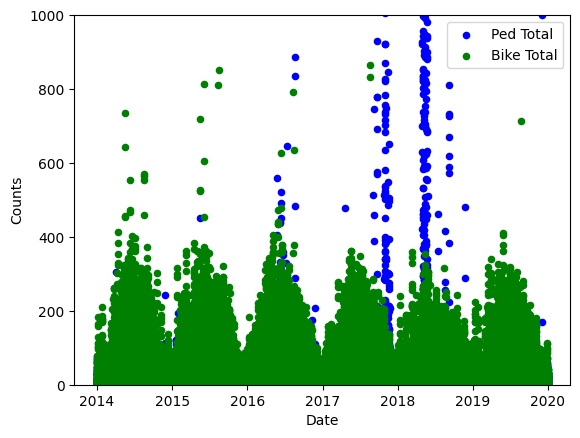

In [20]:
plot_features(
    df, 
    index="Date", 
    features=['Ped Total', 'Bike Total'],  
    plot_type="scatter",
    ylim=(0, 1000)
)

### Much Better!

Now that we've taken care of the null values, we can cast our features to the correct datatypes

In [21]:
df['BGT North of NE 70th Total'] = df['BGT North of NE 70th Total'].astype(np.int64)
df['Ped South'] = df['Ped South'].astype(np.int64)
df['Ped North'] = df['Ped North'].astype(np.int64)
df['Bike North'] = df['Bike North'].astype(np.int64)
df['Bike South'] = df['Bike South'].astype(np.int64)
df['Ped Total'] = df['Ped Total'].astype(np.int64)
df['Bike Total'] = df['Bike Total'].astype(np.int64)

df.drop_duplicates(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52584 entries, 0 to 52583
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        52584 non-null  datetime64[ns]
 1   BGT North of NE 70th Total  52584 non-null  int64         
 2   Ped South                   52584 non-null  int64         
 3   Ped North                   52584 non-null  int64         
 4   Bike North                  52584 non-null  int64         
 5   Bike South                  52584 non-null  int64         
 6   Ped Total                   52584 non-null  int64         
 7   Bike Total                  52584 non-null  int64         
 8   Day                         52584 non-null  int64         
 9   Hour                        52584 non-null  int64         
 10  Day of Week                 52584 non-null  int64         
 11  Month                       52584 non-null  int64     

In [22]:
df

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South,Ped Total,Bike Total,Day,Hour,Day of Week,Month,Year
0,2014-01-01 00:00:00,15,0,2,2,11,2,13,1,0,2,1,2014
1,2014-01-01 01:00:00,9,1,0,1,7,1,8,1,1,2,1,2014
2,2014-01-01 02:00:00,9,0,0,0,9,0,9,1,2,2,1,2014
3,2014-01-01 03:00:00,19,0,0,0,19,0,19,1,3,2,1,2014
4,2014-01-01 04:00:00,19,0,0,0,19,0,19,1,4,2,1,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2019-12-31 19:00:00,6,2,1,1,2,3,3,31,19,1,12,2019
52580,2019-12-31 20:00:00,2,0,0,0,2,0,2,31,20,1,12,2019
52581,2019-12-31 21:00:00,3,1,2,0,0,3,0,31,21,1,12,2019
52582,2019-12-31 22:00:00,1,0,0,0,1,0,1,31,22,1,12,2019


### Data Seasonal Decomposition

In [23]:
def seasonal_decompose(
    df:pd.DataFrame, 
    index:str="Date", 
    feature:str="BGT North of NE 70th Total"
):
    """Function to perform seasonal decomposition analysis on dataframe

    Args:
        df (pd.DataFrame): _description_
        index (str, optional): _description_. Defaults to "Date".
        feature (str, optional): _description_. Defaults to "BGT North of NE 70th Total".
    """
    df_temp = df[[index, feature]]
    df_temp.set_index(index, inplace=True)
    decomposition = sm.tsa.seasonal_decompose(df_temp, model='additive', period=8760)
    fig = decomposition.plot()
    fig.set_size_inches((14, 9))
    fig.tight_layout()
    plt.show()

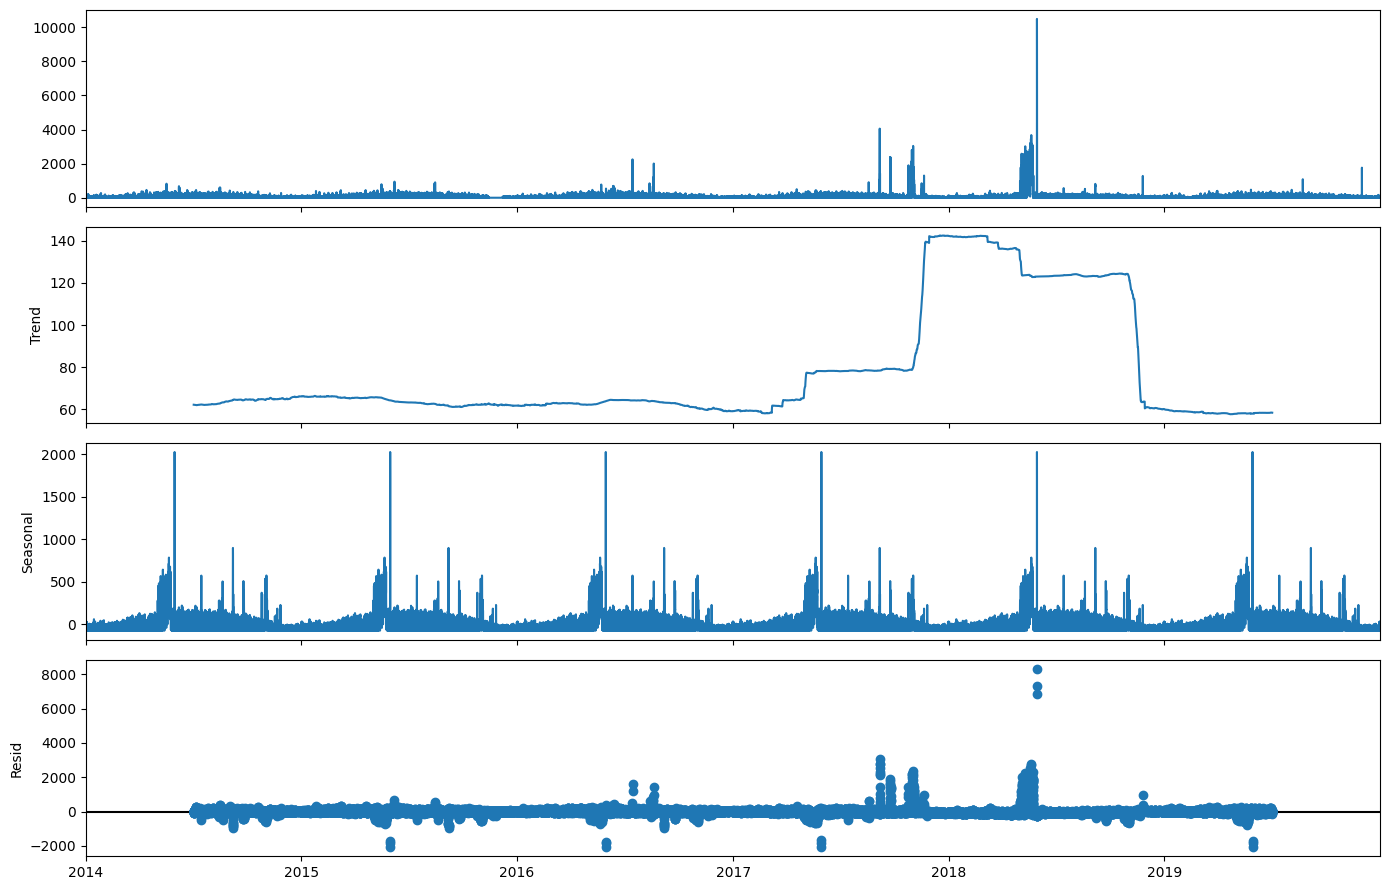

In [24]:
seasonal_decompose(df[['Date', 'BGT North of NE 70th Total']])

### Dicky Fuller Test - Determining If Trend Exists

In [25]:
df_temp = df[['Date', 'BGT North of NE 70th Total']]
df_temp.set_index('Date', inplace=True)

adf, pvalue, usedlag, n_obs, critical_values, icbest = adfuller(df_temp, maxlag=1)
print(f'adf: {adf} \npvalue: {pvalue}\nusedlag: {usedlag}\nn_obs: {n_obs}\ncritical_values: {critical_values}\nicbest: {icbest}')
print('P-Value < 0.05: {}\n'.format(pvalue < 0.05))

adf: -54.5968606675357 
pvalue: 0.0
usedlag: 1
n_obs: 52582
critical_values: {'1%': -3.4304743699224725, '5%': -2.8615949690109987, '10%': -2.566799258176207}
icbest: 640753.4082200413
P-Value < 0.05: True



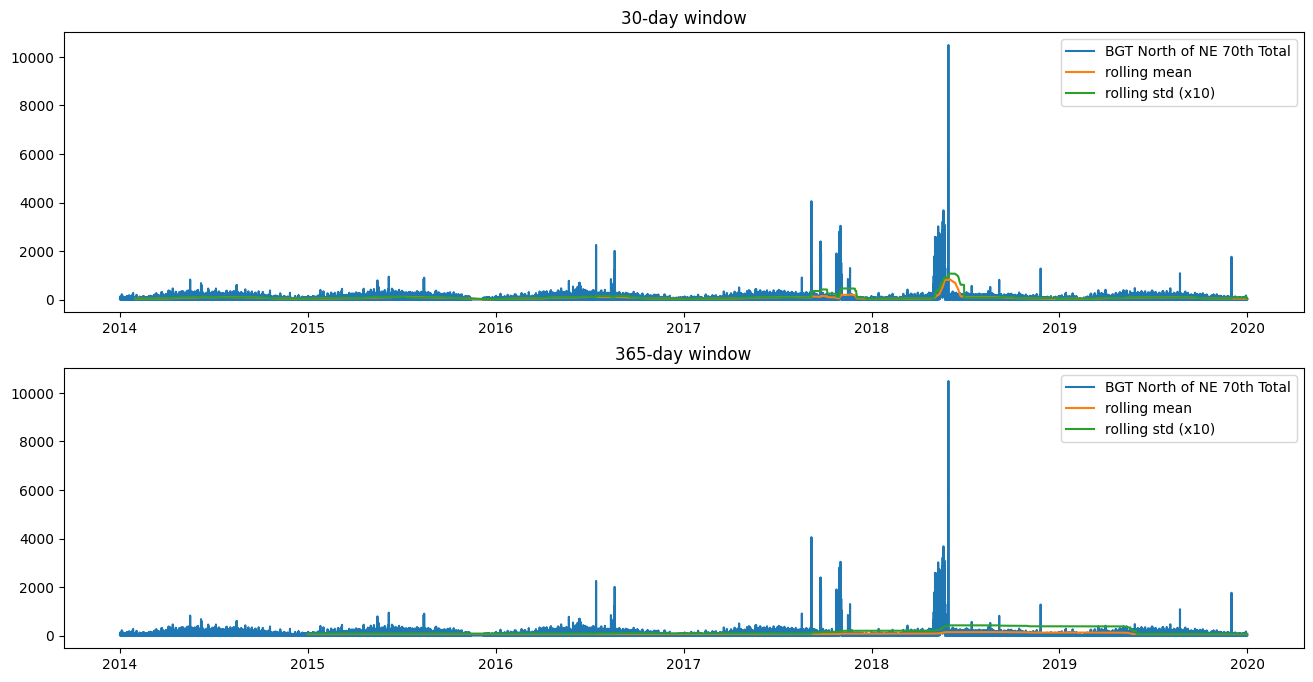

In [26]:
def analyze_stationarity(timeseries, title, monthly_period=730, yearly_period=8760):
    _, ax = plt.subplots(2, 1, figsize=(16, 8))

    rolmean = pd.Series(timeseries).rolling(window=monthly_period).mean() 
    rolstd = pd.Series(timeseries).rolling(window=monthly_period).std()

    ax[0].plot(timeseries, label= title)
    ax[0].plot(rolmean, label='rolling mean');
    ax[0].plot(rolstd, label='rolling std (x10)');
    ax[0].set_title('30-day window')
    ax[0].legend()
    
    rolmean = pd.Series(timeseries).rolling(window=yearly_period).mean() 
    rolstd = pd.Series(timeseries).rolling(window=yearly_period).std()

    ax[1].plot(timeseries, label= title)
    ax[1].plot(rolmean, label='rolling mean');
    ax[1].plot(rolstd, label='rolling std (x10)');
    ax[1].set_title('365-day window')
    ax[1].legend()
    
analyze_stationarity(df_temp['BGT North of NE 70th Total'], 'BGT North of NE 70th Total')


In [27]:
len(df[df.Year.eq(2014)].index)

8760

### Thoughts
- It looks like for the most part the data is stationary
- There exists some points where the Standard Deviation is greater than the mean

## Data Pre-processing for Training/Validation/Test Set

In [30]:
def create_lags(df:pd.DataFrame, target_col:str, lag:int=3) -> pd.DataFrame:
    """_summary_

    Args:
        df (pd.DataFrame): _description_
        target_col (str): _description_
        lag (int, optional): _description_. Defaults to 3.

    Returns:
        pd.DataFrame: _description_
    """
    for i in range(lag): df[f"t-{i+1}"] = df[target_col].shift(i+1)
    return df

In [31]:
df["t"] = df["BGT North of NE 70th Total"]
df = create_lags(df, "BGT North of NE 70th Total", lag=3)

df

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South,Ped Total,Bike Total,Day,Hour,Day of Week,Month,Year,t,t-1,t-2,t-3
0,2014-01-01 00:00:00,15,0,2,2,11,2,13,1,0,2,1,2014,15,NaN,NaN,NaN
1,2014-01-01 01:00:00,9,1,0,1,7,1,8,1,1,2,1,2014,9,15.0,NaN,NaN
2,2014-01-01 02:00:00,9,0,0,0,9,0,9,1,2,2,1,2014,9,9.0,15.0,NaN
3,2014-01-01 03:00:00,19,0,0,0,19,0,19,1,3,2,1,2014,19,9.0,9.0,15.0
4,2014-01-01 04:00:00,19,0,0,0,19,0,19,1,4,2,1,2014,19,19.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2019-12-31 19:00:00,6,2,1,1,2,3,3,31,19,1,12,2019,6,14.0,14.0,40.0
52580,2019-12-31 20:00:00,2,0,0,0,2,0,2,31,20,1,12,2019,2,6.0,14.0,14.0
52581,2019-12-31 21:00:00,3,1,2,0,0,3,0,31,21,1,12,2019,3,2.0,6.0,14.0
52582,2019-12-31 22:00:00,1,0,0,0,1,0,1,31,22,1,12,2019,1,3.0,2.0,6.0
